In [0]:
!pip install shap
!wget "https://drive.google.com/uc?export=download&id=1OMjEx6D_mDSJSb9-fgOfwD19rz0sZ4ra" -O dataset.csv

     |████████████████████████████████| 276kB 3.4MB/s 
  Created wheel for shap: filename=shap-0.35.0-cp36-cp36m-linux_x86_64.whl size=394109 sha256=63f8c82f5de024f1dc4a6672a3732162d268fa52aa8bc462955e6983b33e4bf3
  Stored in directory: /root/.cache/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
Successfully built shap
--2020-05-18 16:35:10--  https://drive.google.com/uc?export=download&id=1OMjEx6D_mDSJSb9-fgOfwD19rz0sZ4ra
Resolving drive.google.com (drive.google.com)... 74.125.69.102, 74.125.69.100, 74.125.69.139, ...
Connecting to drive.google.com (drive.google.com)|74.125.69.102|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-14-4o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/0gcjik2u5gr0bjeb0ki2tpu6bprt5i3h/1589819700000/09214430965896866851/*/1OMjEx6D_mDSJSb9-fgOfwD19rz0sZ4ra?e=download [following]
--2020-05-18 16:35:11--  https://doc-14-4o-docs.googleusercontent.com/docs/se

In [0]:
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))

import IPython

IPython.get_ipython().events.register('pre_run_cell', configure_plotly_browser_state)

In [0]:
import numpy as np
import pandas as pds
import seaborn as sns
import shap
import matplotlib
import matplotlib.pyplot as plt #visualization
%matplotlib inline

plt.rcParams["figure.figsize"] = (16,11)
font = {'weight' : 'normal',
        'size'   : 16}
matplotlib.rc('font', **font)

import itertools
import warnings
warnings.filterwarnings("ignore")
import os
import io
import plotly.offline as py #visualization
py.init_notebook_mode(connected=True) #visualization
import plotly.graph_objs as go #visualization
import plotly.tools as tls #visualization
import plotly.figure_factory as ff #visualization

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
data = pds.read_csv('dataset.csv')
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [0]:
clean_column_name = []
columns = data.columns
for i in range(len(columns)):
    clean_column_name.append(columns[i].lower())
data.columns = clean_column_name

In [0]:
data = data.drop(["rownumber", "customerid", "surname"], axis=1)

In [0]:
print(data.shape)
data.head()

(10000, 11)


,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [0]:
np.sum(data.isna())

creditscore        0
geography          0
gender             0
age                0
tenure             0
balance            0
numofproducts      0
hascrcard          0
isactivemember     0
estimatedsalary    0
exited             0
dtype: int64

# Analyse exploratoire et Data Visualization

L'objectif de cette partie est de répondre à des questions que l'on se pose dans le but d'acquérir de la connaissance sur les données. Pour mener à bien cette partie, il faut se mettre dans la tête d'une personne qui ne connaît ni la situation, ni les données et qui poserait des questions essentielles.

## Analyse univariée

Effectuons une première visualisation de l'état du compte bancaire au moment de la récupération du jeu de données.

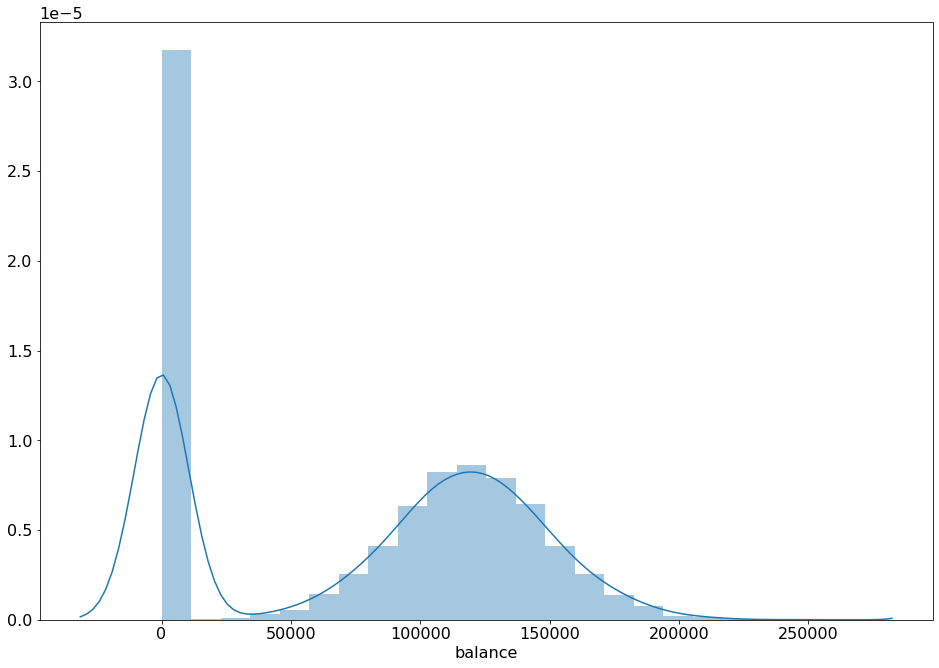

In [0]:
sns.distplot(data['balance'])

Nous observons une forte proportion d'individus ayant un compte bancaire à 0€ le jour de la récupération des informations. Pour autant, cela signifie-t-il qu'il y a eu autant d'individus ayant exactement 0€ sur leur compte bancaire ce jour-là ?

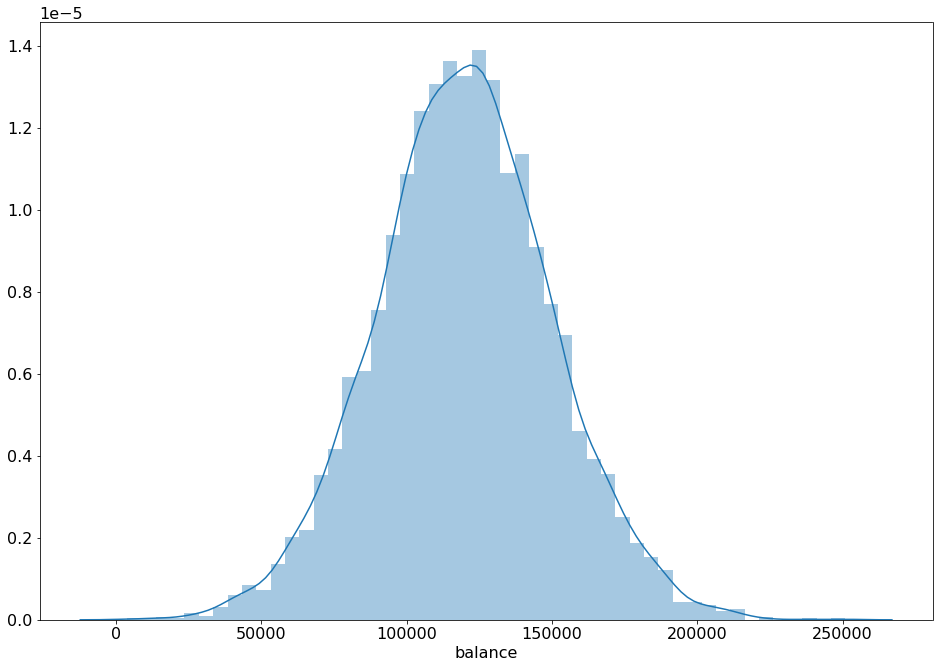

In [0]:
sns.distplot(data['balance'][data['balance'] > 0])

## Analyse multivariée

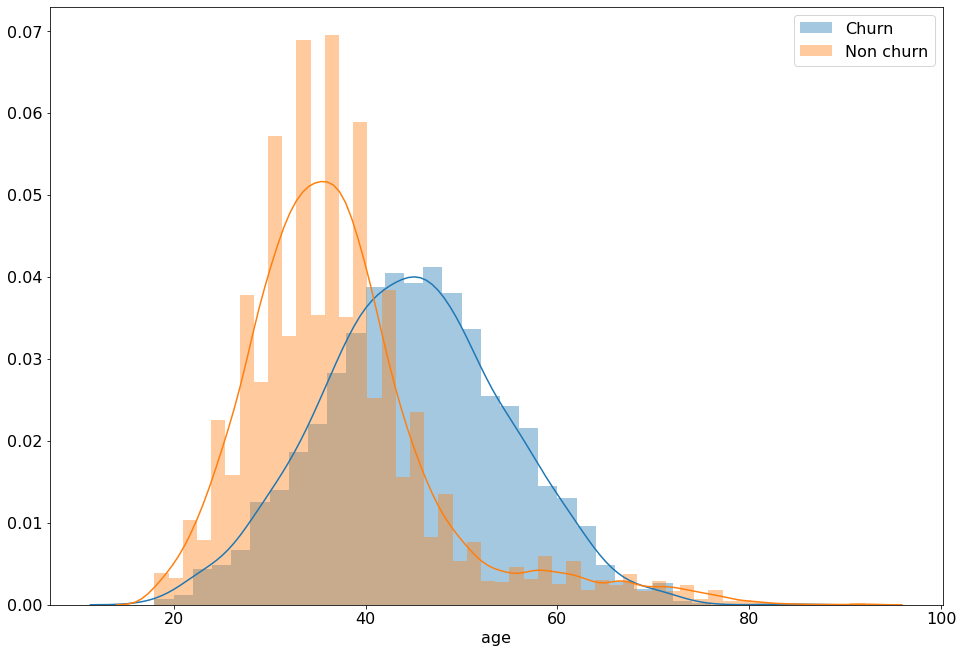

In [0]:
sns.distplot(data.loc[data['exited'] == 1, 'age'], label="Churn")
sns.distplot(data.loc[data['exited'] == 0, 'age'], label="Non churn")
plt.legend()

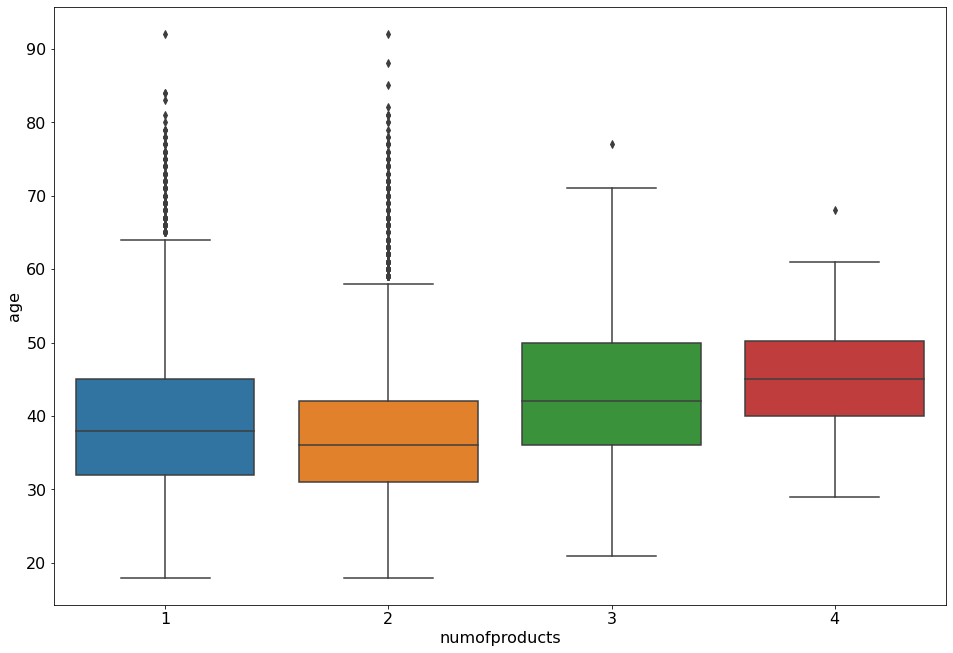

In [0]:
sns.boxplot(x='numofproducts', y='age', data=data)

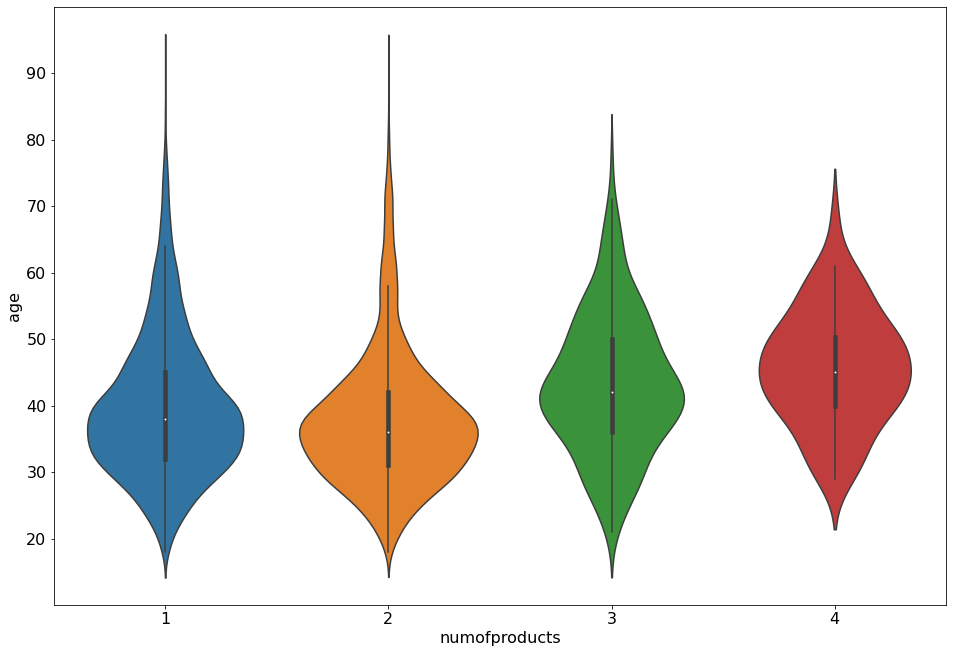

In [0]:
sns.violinplot(x='numofproducts', y='age', data=data)

### Analyse de la variable réponse

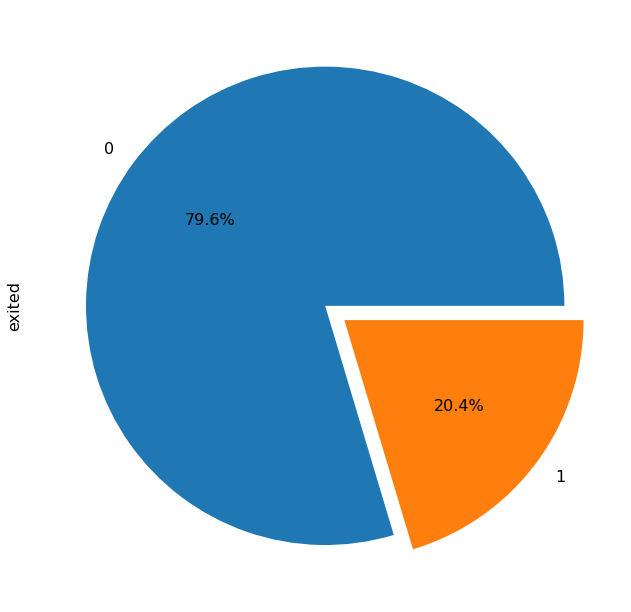

In [0]:
data['exited'].value_counts().plot.pie(autopct=lambda x: '{:2.1f}%'.format(x), explode=[0, 0.1])

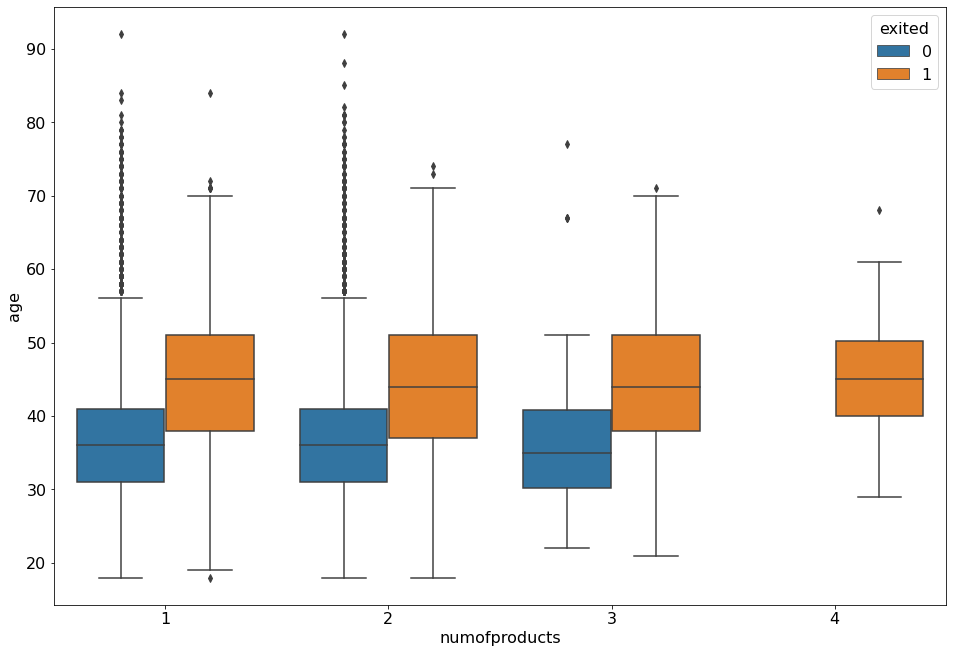

In [0]:
sns.boxplot(x='numofproducts', y='age', data=data, hue="exited")

In [0]:
data[(data['exited'] == 1) & (data['numofproducts'] == 4)].shape

(60, 11)

# Nettoyage

In [0]:
cleaned_data = data.copy()
cleaned_data = cleaned_data[~((cleaned_data['exited'] == 1) & (cleaned_data['numofproducts'] == 4))]
cleaned_data.shape

(9940, 11)

# Encodage

In [0]:
X = cleaned_data.iloc[:, :-1].copy()
y = cleaned_data['exited']
X.head()

,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary
0,619,France,Female,42,2,0.00,1,1,1,101348.88
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58
2,502,France,Female,42,8,159660.80,3,1,0,113931.57
3,699,France,Female,39,1,0.00,2,0,0,93826.63
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10


## Encodage binaire

In [0]:
X['gender'] = data['gender'].apply(lambda x: 1 if x == "Female" else 0)
X.head()

,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary
0,619,France,1,42,2,0.00,1,1,1,101348.88
1,608,Spain,1,41,1,83807.86,1,0,1,112542.58
2,502,France,1,42,8,159660.80,3,1,0,113931.57
3,699,France,1,39,1,0.00,2,0,0,93826.63
4,850,Spain,1,43,2,125510.82,1,1,1,79084.10


In [0]:
X = X.join(pds.get_dummies(data['geography']))
X.head()

,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,France,Germany,Spain
0,619,France,1,42,2,0.00,1,1,1,101348.88,1,0,0
1,608,Spain,1,41,1,83807.86,1,0,1,112542.58,0,0,1
2,502,France,1,42,8,159660.80,3,1,0,113931.57,1,0,0
3,699,France,1,39,1,0.00,2,0,0,93826.63,1,0,0
4,850,Spain,1,43,2,125510.82,1,1,1,79084.10,0,0,1


In [0]:
del X['geography']
X.head()

,creditscore,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,France,Germany,Spain
0,619,1,42,2,0.00,1,1,1,101348.88,1,0,0
1,608,1,41,1,83807.86,1,0,1,112542.58,0,0,1
2,502,1,42,8,159660.80,3,1,0,113931.57,1,0,0
3,699,1,39,1,0.00,2,0,0,93826.63,1,0,0
4,850,1,43,2,125510.82,1,1,1,79084.10,0,0,1


In [0]:
clean_column_name = []
columns = X.columns
for i in range(len(columns)):
    clean_column_name.append(columns[i].lower())
X.columns = clean_column_name
X.head()

,creditscore,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,france,germany,spain
0,619,1,42,2,0.00,1,1,1,101348.88,1,0,0
1,608,1,41,1,83807.86,1,0,1,112542.58,0,0,1
2,502,1,42,8,159660.80,3,1,0,113931.57,1,0,0
3,699,1,39,1,0.00,2,0,0,93826.63,1,0,0
4,850,1,43,2,125510.82,1,1,1,79084.10,0,0,1


Avant d'entraîner un modèle, il faut s'assurer que l'on sépare bien le jeu de données en deux ensembles :

- Un ensemble de train
- Un ensemble de test

Il est essentiel de séparer le jeu de données en deux : on veut se rapprocher au maximum du séparateur en noir, pas en vert.

<center>
  <img width="400" src="https://upload.wikimedia.org/wikipedia/commons/thumb/1/19/Overfitting.svg/1200px-Overfitting.svg.png" />
</center>

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Modélisation

In [0]:
tree = DecisionTreeClassifier(max_depth=6)
tree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=6, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [0]:
from sklearn.metrics import accuracy_score

print("Train :", accuracy_score(y_train, tree.predict(X_train)))
print("Test :", accuracy_score(y_test, tree.predict(X_test)))

Train : 0.8649037079620581
Test : 0.8537894030851777


In [0]:
features_imp = pds.DataFrame(
    data=np.asarray([X.columns, tree.feature_importances_]).transpose(),
    columns=['Variable', 'Importance'])
features_imp

,Variable,Importance
0,creditscore,0.00297241
1,gender,0.0026578
2,age,0.436131
3,tenure,0.00240924
4,balance,0.0735776
5,numofproducts,0.253759
6,hascrcard,0
7,isactivemember,0.182184
8,estimatedsalary,0.00611483
9,france,0.00423517


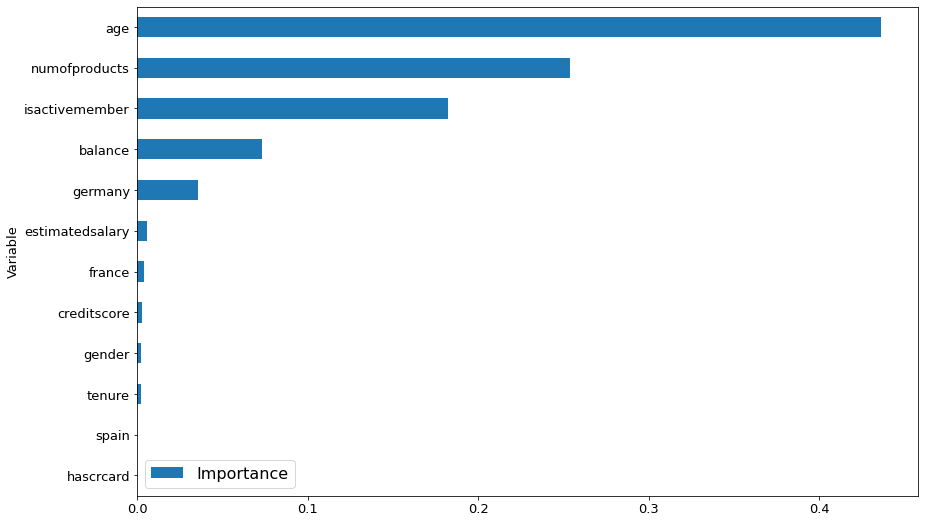

In [0]:
features_imp.set_index("Variable").sort_values(by="Importance").plot.barh(figsize=(14, 9))
for item in ([plt.gca().title, plt.gca().xaxis.label, plt.gca().yaxis.label] +
             plt.gca().get_xticklabels() + plt.gca().get_yticklabels()):
    item.set_fontsize(13)

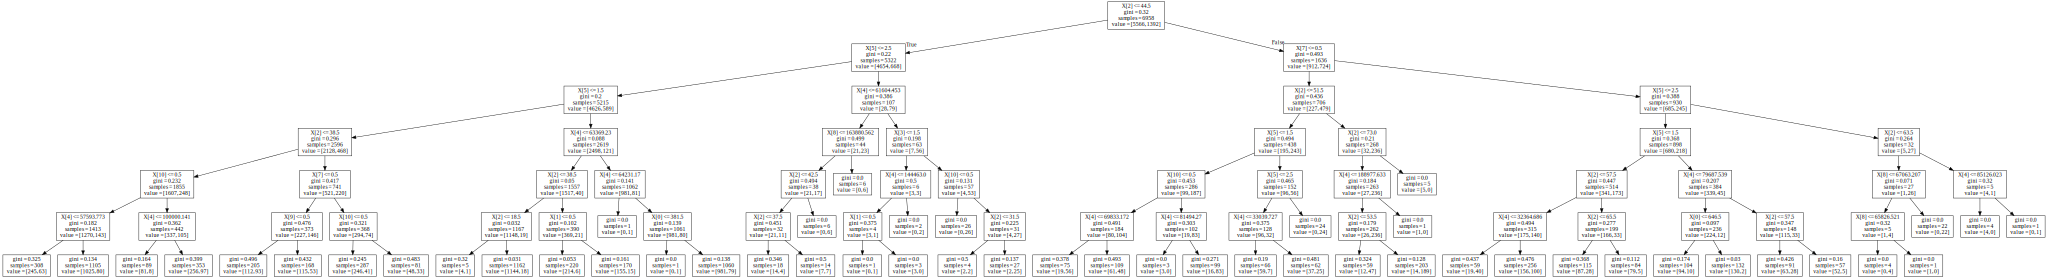

In [0]:
import graphviz 
import sklearn.tree

dot_data = sklearn.tree.export_graphviz(tree, out_file=None) 
graph = graphviz.Source(dot_data)
graph